# NWP Forecast Quality Evaluation

This notebook evaluates the quality of ICON-D2 weather forecasts by comparing predicted wind speeds at 10m height with measured wind speeds from synthetic data.

**Metrics calculated:**
- R² (Coefficient of Determination)
- RMSE (Root Mean Square Error)
- MAE (Mean Absolute Error)

**Comparison:**
- Measured: `wind_speed` from synth CSV
- Predicted: `wind_speed_h10_n` from ICON-D2 (n = grid point)

## 1. Imports and Configuration

In [18]:
import os
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from utils import preprocessing
import logging
from tqdm import tqdm
import re
from collections import defaultdict

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [17]:
# Load configuration
config_path = 'configs/config_wind_100.yaml'

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print(f"✓ Loaded config: {config_path}")
print(f"  Synth data path: {config['data']['path']}")
print(f"  NWP path: {config['data']['nwp_path']}")
print(f"  Test end: {config['data']['test_end']}")

next_n_grid_points = 1

✓ Loaded config: configs/config_wind_100.yaml
  Synth data path: /mnt/nas/synthetic/wind/wind_hourly_age_20251103
  NWP path: /mnt/nas/icon-d2/csv
  Test end: 2025-10-21


## 2. Load All Station Data

In [4]:
# Parameters for data loading
test_end = pd.Timestamp(config['data']['test_end']).tz_localize('UTC')

print(f"Time range: up to {test_end}")

Time range: up to 2025-10-21 00:00:00+00:00


In [ ]:
# Get list of synth files
synth_path = Path(config['data']['path'])
synth_files = sorted(synth_path.glob('synth_*.csv'))
features = preprocessing.get_features(config=config)
features['known'].extend(['wind_speed_h10', 'wind_speed'])
features['observed'] = []
features['static'] = []
config['params']['next_n_grid_points'] = next_n_grid_points

print(f"Found {len(synth_files)} station files")

# Load data for all stations
station_data = {}
failed_stations = []

for synth_file in tqdm(synth_files, desc="Loading stations"):
    station_id = synth_file.stem.replace('synth_', '')

    try:
        # Load data using preprocessing function
        df = preprocessing.preprocess_synth_wind_icond2(
            path=str(synth_file),
            config=config,
            features=features
        )
        # Filter to test_end
        if isinstance(df.index, pd.MultiIndex):
            df = df[df.index.get_level_values('timestamp') <= test_end]
        else:
            df = df[df.index <= test_end]

        station_data[station_id] = df

    except Exception as e:
        logger.error(f"Failed to load station {station_id}: {e}")
        failed_stations.append(station_id)

print(f"\n✓ Loaded {len(station_data)} stations successfully")
if failed_stations:
    print(f"⚠️ Failed to load {len(failed_stations)} stations")
    print(f"   First 10: {failed_stations[:10]}")

Found 203 station files


Loading stations: 100%|██████████| 203/203 [47:33<00:00, 14.05s/it] 


✓ Loaded 203 stations successfully


## 3. Calculate Metrics Table

Calculate R², RMSE, and MAE for each station comparing measured wind speed with NWP forecast at a specific grid point.

In [ ]:
print(f"📊 Calculating metrics for grid point {grid_point_n}...\n")

📊 Calculating metrics for grid point 1...



In [ ]:
metrics_results = defaultdict(dict)
hours = [6, 9, 12, 15]

for station_id, df_orig in tqdm(station_data.items(), desc="Calculating metrics"):
    for hour in hours:
        df = df_orig[df_orig.index.get_level_values('starttime').hour == hour]

        if df.empty: continue

        y_true = df['wind_speed'].values
        y_pred = df[nwp_col].values

        metrics_results[station_id].update({
            f'R²_{hour}': r2_score(y_true, y_pred),
            f'RMSE_{hour}': np.sqrt(mean_squared_error(y_true, y_pred)),
            f'MAE_{hour}': mean_absolute_error(y_true, y_pred)
        })

metrics_df = pd.DataFrame(metrics_results).T

# 1. Sort Columns: R² (all hours), then RMSE, then MAE
sorted_cols = [f'{metric}_{h}' for metric in ['R²', 'RMSE', 'MAE'] for h in hours]
metrics_df = metrics_df.reindex(columns=sorted_cols)

# 2. Sort Rows by Mean R²
r2_cols = [c for c in metrics_df.columns if 'R²' in c]
metrics_df['Mean_R²'] = metrics_df[r2_cols].mean(axis=1)
metrics_df = metrics_df.sort_values('Mean_R²', ascending=False)

# Move Mean_R² to front for better visibility
cols = ['Mean_R²'] + [c for c in metrics_df.columns if c != 'Mean_R²']
metrics_df = metrics_df[cols]

print(f"\n📋 Metrics for grid point {grid_point_n} ({nwp_col}):\n")
print(metrics_df.to_string(float_format="%.4f"))

metrics_df.to_csv(f"metrics_{nwp_col}_grid_point_{grid_point_n}.csv")


Calculating metrics: 100%|██████████| 203/203 [00:04<00:00, 44.33it/s]


📋 Metrics for grid point 1 (wind_speed_h10_1):

       Mean_R²    R²_6    R²_9   R²_12   R²_15  RMSE_6  RMSE_9  RMSE_12  RMSE_15  MAE_6  MAE_9  MAE_12  MAE_15
00298   0.7957  0.7965  0.7953  0.7930  0.7981  1.1243  1.1273   1.1336   1.1169 0.8596 0.8561  0.8615  0.8498
00963   0.7854  0.7824  0.7829  0.7875  0.7889  1.0191  1.0172   1.0064   1.0044 0.7731 0.7768  0.7688  0.7642
02907   0.7803  0.7759  0.7792  0.7834  0.7825  1.1764  1.1673   1.1562   1.1586 0.8781 0.8726  0.8680  0.8640
00704   0.7785  0.7773  0.7750  0.7769  0.7849  0.8819  0.8862   0.8824   0.8694 0.6667 0.6706  0.6678  0.6551
07351   0.7777  0.7778  0.7775  0.7757  0.7800  0.9007  0.9010   0.9046   0.8980 0.6798 0.6789  0.6794  0.6725
04745   0.7766  0.7729  0.7742  0.7766  0.7826  0.8156  0.8127   0.8085   0.7979 0.6201 0.6173  0.6134  0.6035
02564   0.7742  0.7757  0.7773  0.7708  0.7729  1.0162  1.0124   1.0270   1.0220 0.7636 0.7575  0.7673  0.7595
00342   0.7653  0.7626  0.7622  0.7656  0.7707  0.9945  0.9948 

## 4. Visualize Specific Forecast

Plot measured vs. predicted wind speeds for a specific station and forecast run.

In [ ]:
# PARAMETERS
station_id = '00164'  # Station to plot
forecast_start = '2025-08-01 06:00'  # Forecast start time (YYYY-MM-DD HH:MM)
plot_heights = True  # Whether to plot other NWP heights (h78, h127, etc.)

print(f"Plotting forecast for station {station_id} at {forecast_start} (UTC)")

Plotting forecast for station 00164 at 2025-08-01 06:00


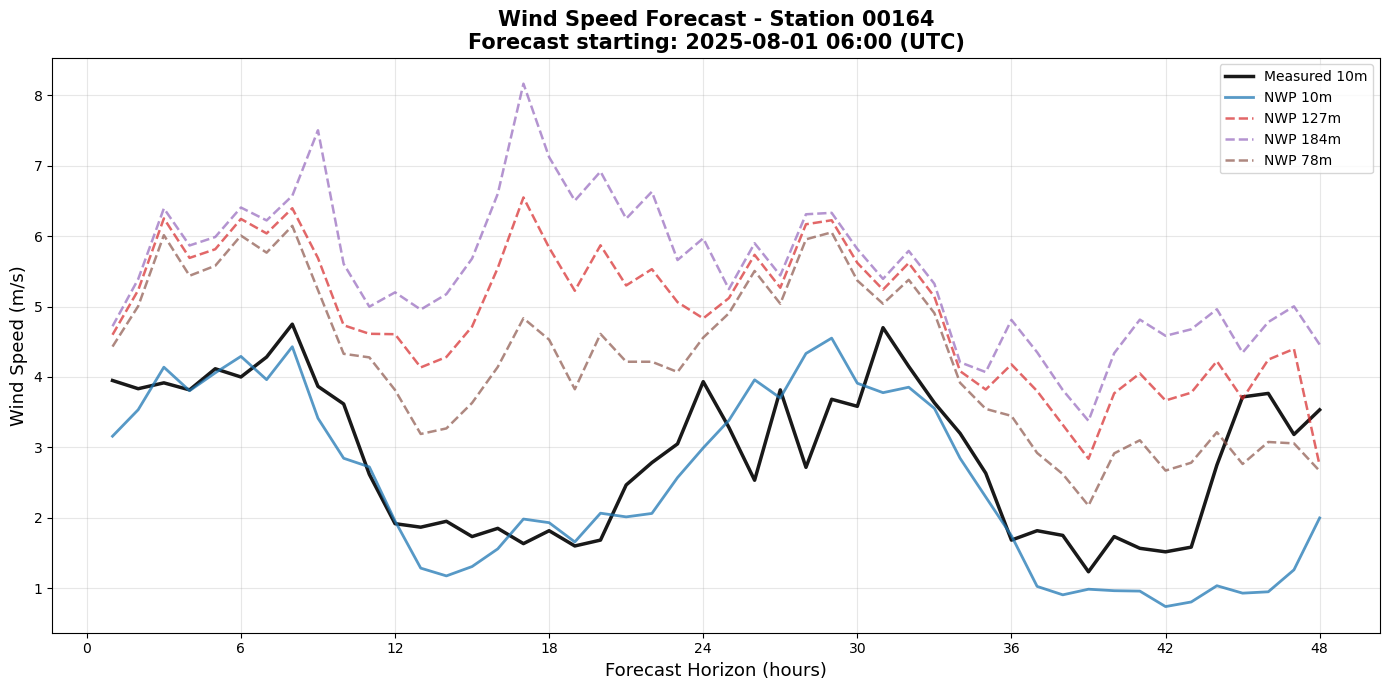

✓ Plot generated for station 00164, forecast 2025-08-01 06:00


In [34]:
# Get data for selected station
if station_id not in station_data:
    raise ValueError(f"Station {station_id} not found in loaded data")

df_station = station_data[station_id]

# Parse forecast run timestamp
#forecast_start = pd.Timestamp(forecast_run)

forecast_mask = df_station.index.get_level_values('starttime') == forecast_start
forecast_data = df_station.loc[forecast_mask]

measured_wind = forecast_data['wind_speed'].values

# Find all h10 columns
h10_cols = [col for col in forecast_data.columns if 'wind_speed_h10_' in col]
h10_cols = sorted(h10_cols)

# Find other height columns if plot_heights is True
other_height_cols = []
if plot_heights:
    other_height_cols = [col for col in forecast_data.columns
                        if 'wind_speed_h' in col and 'h10' not in col and col.endswith('_1')]
    other_height_cols = sorted(other_height_cols)[:3]  # Take up to 3 heights

# Create plot
fig, ax = plt.subplots(figsize=(14, 7), dpi=100)

# X-axis
x = np.arange(1, len(timestamps) + 1)

# Plot measured wind speed
ax.plot(x, measured_wind, 'k-', linewidth=2.5, label='Measured 10m', alpha=0.9)

# Plot NWP forecasts at 10m (for each grid point)
colors_10m = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, orange, green
for idx, col in enumerate(h10_cols[:3]):
    grid_n = col.split('_')[-1]
    ax.plot(x, forecast_data[col].values, '-',
           color=colors_10m[idx], linewidth=2,
           label=f'NWP 10m', alpha=0.75)

# Plot other heights if requested
if plot_heights and other_height_cols:
    colors_heights = ['#d62728', '#9467bd', '#8c564b']  # Red, purple, brown
    for idx, col in enumerate(other_height_cols):
        # Extract height from column name
        match = re.search(r'_h(\d+)_', col)
        if match:
            height = match.group(1)
            ax.plot(x, forecast_data[col].values, '--',
                   color=colors_heights[idx], linewidth=1.8,
                   label=f'NWP {height}m', alpha=0.7)

# Formatting
ax.set_xlabel('Forecast Horizon (hours)', fontsize=13)
ax.set_ylabel('Wind Speed (m/s)', fontsize=13)
ax.set_xticks(np.arange(0, len(x) + 1, 6))
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.title(f'Wind Speed Forecast - Station {station_id}\nForecast starting: {forecast_start} (UTC)',
         fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"✓ Plot generated for station {station_id}, forecast {forecast_run}")